<a href="https://colab.research.google.com/github/zengxuhe/pyGAD-kerastuner/blob/main/group(final)(13_8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/keras-team/keras-tuner

Cloning into 'keras-tuner'...
remote: Enumerating objects: 7099, done.
remote: Counting objects: 100% (457/457), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 7099 (delta 252), reused 397 (delta 231), pack-reused 6642
Receiving objects: 100% (7099/7099), 1.53 MiB | 4.34 MiB/s, done.
Resolving deltas: 100% (4957/4957), done.


In [2]:
cd keras-tuner

/content/keras-tuner


In [3]:
!pip install .

Processing /content/keras-tuner
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-py3-none-any.whl size=97186 sha256=911ba96e87398d399d8a3316b4ca1bab13d164cff6dd23cd67cbebd493b75257
  Stored in directory: /root/.cache/pip/wheels/7a/f4/56/f120140a3c0706aebedf4471bfee8f02bbce4755424e32e245
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=35fa2a5175cb9af3cb5e6999c3c2f2e8c56564008fd5cca69645d955056d10e9
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built keras-tuner kt-legacy


In [ ]:
# Train a DNN model for prediction

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kerastuner as kt

# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x_test = x[110:119,:]
x = x [0:110,:]


y = data.loc[0:119, ['target']]
y=np.array(y)
y_target= y[110:119,:]
y_mean = np.mean(y,axis=0)
y_std = np.std(y,axis=0)
y = (y-y_mean)/y_std
y = y [0:110,:]



np.random.seed(3)
np.random.shuffle(x)
np.random.seed(3)
np.random.shuffle(y)

x_train = x[0:100,:]
x_val = x[100:110,:]
y_train = y[0:100,:]
y_val = y[100:110,:]


#Define model
def model_builder(hp):
  model = keras.Sequential()
#Set the input layer
  model.add(keras.layers.Flatten(input_shape=(5,1)))
#Set dropout rate search space
  drop_rate = hp.Choice('drop_rate', 
                            [0.0, 0.1, 0.2, 0.3, 0.4,])
#Set activation function search space
  activation = hp.Choice('activation', 
                            ['relu', 'tanh', 'sigmoid'])
#In here, we tuner the number of layers using for loop
  for i in range(hp.Int('num_layers', 2 , 5)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                      min_value=5,
                      max_value=50,
                      step=1),
                activation= activation))
  model.add(keras.layers.Dropout(rate=drop_rate))
  model.add(keras.layers.Dense(1, activation='linear'))
#  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
  model.compile(
          optimizer= optimizer,
          loss='mean_absolute_error',
          metrics=['mean_absolute_error'])

#          optimizer=tf.keras.optimizers.optimizer(lr=hp_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08),

  return model
tuner = kt.RandomSearch(model_builder,
                     objective='val_mean_absolute_error',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='255245112154156315312654245298')
# represent the search space
tuner.search_space_summary()

# search the best hyperparameters
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train,y_train,epochs=50,validation_split=0.2,callbacks=[stop_early])

# recall the overall hyperparameters
tuner.results_summary()

# train model with the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


history=model.fit(x_train, y_train, batch_size=16, epochs=300, validation_data=(x_val,y_val), validation_freq=1, shuffle=False)


# plot the figure illustrating the training loss and validation loss
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
x = np.array([10,10,65,50,5])
x=x.reshape(1,5)
y=model(x)
print(y)
#manifest the model structure
model.summary()

#extract the best hyperparameters 
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/300
7/7 [==============================] - 0s 19ms/step - loss: 0.6610 - mae: 0.6610 - val_loss: 0.9406 - val_mae: 0.9406
Epoch 2/300
7/7 [==============================] - 0s 4ms/step - loss: 0.6159 - mae: 0.6159 - val_loss: 0.8943 - val_mae: 0.8943
Epoch 3/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5883 - mae: 0.5883 - val_loss: 0.8694 - val_mae: 0.8694
Epoch 4/300
7/7 [==============================] - 0s 4ms/step - loss: 0.5622 - mae: 0.5622 - val_loss: 0.8280 - val_mae: 0.8280
Epoch 5/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5522 - mae: 0.5522 - val_loss: 0.7959 - val_mae: 0.7959
Epoch 6/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5470 - mae: 0.5470 - val_loss: 0.7776 - val_mae: 0.7776
Epoch 7/300
7/7 [==============================] - 0s 4ms/step - loss: 0.5265 - mae: 0.5265 - val_loss: 0.7630 - val_mae: 0.7630
Epoch 8/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5152 - mae: 0.5152 - va

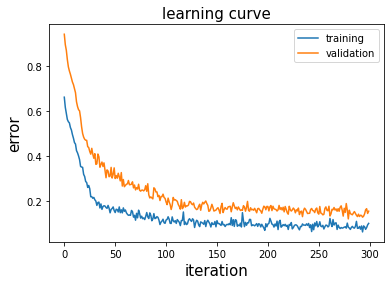

tf.Tensor(
[[0.87386036]
 [0.50358033]
 [0.39900303]
 [0.4125924 ]
 [0.00455457]
 [0.30115223]
 [0.06647325]
 [0.12562633]
 [0.04529142]], shape=(9, 1), dtype=float32)
tf.Tensor(
[[0.05333946]
 [0.1361028 ]
 [0.08254097]
 [0.09038169]
 [0.00709435]
 [0.11120836]
 [0.03992387]
 [0.04193135]
 [0.01572619]], shape=(9, 1), dtype=float32)


In [127]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kerastuner as kt
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# upload the data base at the certain path
data = pd.read_csv('/content/traincmp.csv')


x = data.loc[0:119, ['A','B','C','D','E']]
x =np.array(x)
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x_test = x[110:119,:]
x = x [0:110,:]


y = data.loc[0:119, ['target']]
y=np.array(y)
y_target= y[110:119,:]
y_mean = np.mean(y,axis=0)
y_std = np.std(y,axis=0)
y = (y-y_mean)/y_std
y = y [0:110,:]



np.random.seed(3)
np.random.shuffle(x)
np.random.seed(3)
np.random.shuffle(y)

x_train = x[0:100,:]
x_val = x[100:110,:]
y_train = y[0:100,:]
y_val = y[100:110,:]


model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(5,1)),
        tf.keras.layers.Dense(46, activation=tf.nn.relu),
        tf.keras.layers.Dense(34, activation=tf.nn.relu),
        tf.keras.layers.Dense(28, activation=tf.nn.relu),
        tf.keras.layers.Dense(33, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='linear')
])
#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
#Adagrad(lr=0.01, epsilon=1e-06)
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
          loss='mae',
          metrics=['mae'])

history=model.fit(x_train, y_train, batch_size=16, epochs=300, validation_data=(x_val,y_val), validation_freq=1, shuffle=False)
#history=model.fit(x_train, y_train, batch_size=16, epochs=200, validation_split=0.2, validation_freq=1,shuffle=False)

model.summary()



epochs = len(history.history['loss'])
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],label='training')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'],label='validation')
plt.legend(fontsize=10)
plt.title('learning curve',fontsize=15)
plt.xlabel('iteration',fontsize=15)
plt.ylabel('error',fontsize=15)
plt.show()
y_test=model(x_test)
y_mid= tf.multiply(y_test,y_std)
y_test= tf.add(y_mid, y_mean)
error= tf.abs(tf.subtract(y_test, y_target))
error_percentage = tf.divide(error, y_target)
print(error)
print(error_percentage)

In [26]:
!pip3 install pygad

     |████████████████████████████████| 52 kB 1.2 MB/s 


/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:731: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


Generation = 1
Fitness    = [3.908528]
Change     = [3.908528]
Generation = 2
Fitness    = [3.908528]
Change     = [0.]
Generation = 3
Fitness    = [3.9344234]
Change     = [0.02589536]
Generation = 4
Fitness    = [3.9344234]
Change     = [0.]
Generation = 5
Fitness    = [3.982496]
Change     = [0.04807258]
Generation = 6
Fitness    = [3.982496]
Change     = [0.]
Generation = 7
Fitness    = [3.982496]
Change     = [0.]
Generation = 8
Fitness    = [3.9932117]
Change     = [0.01071572]
Generation = 9
Fitness    = [3.9932117]
Change     = [0.]
Generation = 10
Fitness    = [4.01582]
Change     = [0.02260828]
Generation = 11
Fitness    = [4.01582]
Change     = [0.]
Generation = 12
Fitness    = [4.01582]
Change     = [0.]
Generation = 13
Fitness    = [4.01582]
Change     = [0.]
Generation = 14
Fitness    = [4.01582]
Change     = [0.]
Generation = 15
Fitness    = [4.01582]
Change     = [0.]
Generation = 16
Fitness    = [4.01582]
Change     = [0.]
Generation = 17
Fitness    = [4.01582]
Change 

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:3105: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


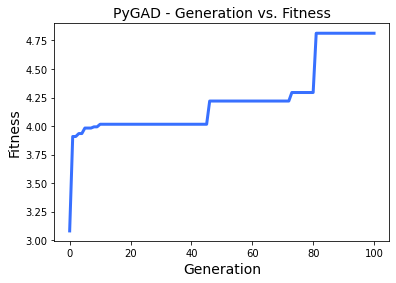

Parameters of the best solution : [11.71565336 13.74696652 78.90247369 69.26924224  4.80344359]
Fitness value of the best solution = [0.20775336]


In [133]:
# Optimization for input features

import numpy as np
import pygad

#initialization
function_inputs = [0.5,0.5,0.5,0.5,0.5]

#define fitness function
def fitness_func(solution, solution_idx):
    target = [1.5]
    target = abs(y-y_mean)/y_std
    output=model(np.array(solution*function_inputs).reshape(1,5)) # model is built in keras.tuner
    output = abs(tf.subtract(abs(output), abs(target)))
    fitness =((1/output)).numpy()[0]
    #fitness =output.numpy()[0]
    return fitness

# Number of generations.
num_generations = 100
# Number of solutions to be selected as parents in the mating pool.
num_parents_mating = 5 
# Number of solutions in the population.
sol_per_pop = 10 
  
# Type of parent selection.
parent_selection_type = "sss"
# Type of the crossover operator.
crossover_type = "single_point" 
# Type of the mutation operator.
mutation_type = "random"

last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(
     #Number of generations(iterations).
     num_generations=num_generations,
     num_parents_mating=num_parents_mating,
     fitness_func=fitness_func,
     sol_per_pop=sol_per_pop,
     #the Number of parameters(the number of genes)
     num_genes=5,
     gene_space=[np.arange(-1.68,2.88,0.01).tolist(),np.arange(-1.34,1.73,0.01).tolist(),np.arange(-0.88,1.56,0.01).tolist(),np.arange(-0.99,1.32,0.01).tolist(),
                 np.arange(-1.26,-0.392,0.01).tolist()],
     
     parent_selection_type=parent_selection_type,
     keep_parents=1,
     crossover_type=crossover_type,
     mutation_percent_genes=50,
     mutation_type=mutation_type,
     callback_generation=callback_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()


# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
solution = tf.multiply(solution,x_std)
solution = tf.add(solution, x_mean)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))

In [128]:
save_path = r'E:\model\group13(13.8).h5'
model.save(save_path)

In [129]:
print(y_test)

tf.Tensor(
[[15.509139  ]
 [ 4.2035804 ]
 [ 4.434997  ]
 [ 4.1524076 ]
 [ 0.63744545]
 [ 2.4068477 ]
 [ 1.7314732 ]
 [ 3.1216264 ]
 [ 2.8347087 ]], shape=(9, 1), dtype=float32)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


figsize = 8,5
figure, ax = plt.subplots(figsize=figsize)

x = np.array([1,2,3,4,5,6,7,8,9])
y1 = np.array([16.383, 3.7, 4.834, 4.565, 0.642, 2.708, 1.665, 2.996, 2.88])
y2 = np.array([14.461, 3.437, 3.995, 3.758, 0.727, 2.615, 1.575, 3.076, 2.815])
s1 = plt.scatter(x,y1, s=50, c= 'b', marker='^')
s2 = plt.scatter(x,y2, s=50, c= 'r', marker='^')
plt.xlabel('Number of group',fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.title('The results comparison',fontsize=18)
plt.legend((s1,s2),('experimental results','prediction results') ,loc = 'best',fontsize=12)

plt.show()